# Premise
[_The Witcher 2_](http://thewitcher.com/en/witcher2) has a mini ingame that can be played with some of the NPCs, called _Dice_. The game is played between two players. At the beginning both players bet some money, then each of them rolls 5 (6 sided) dices. Both can see the other's dices. After the dices have been rolled, bets can be raised and then each player chooses between 0 and 5 (inclusive) of his/her dices to roll a second time. Once both players have rolled dices a second time, a winner or a tie is decided based on some set of rules that assign ranking to a collection of 5 dices. Detailed rules can be found in the [game's wiki](http://witcher.wikia.com/wiki/Dice_poker_in_The_Witcher_2).

From the [wiki](http://witcher.wikia.com/wiki/Dice_poker_in_The_Witcher_2), the winning combinations are (highest to lowest):
1. __Five-of-a-kind__ - five dice showing the same value
2. __Four-of-a-kind__ - four dice showing the same value
3. __Full House__ - a pair and a three-of-a-kind
4. __Six-high straight__ - dice showing II, III, IV, V and VI
5. __Five-high straight__ - dice showing I, II, III, IV and V
6. __Three-of-a-kind__ - three dice showing the same value
7. __Two pairs__ - dice showing two matched pairs of values
8. __One pair__ - dice showing a single matched pair of values
9. __Nothing__ - none of the above


Some of the terminology that we use throughout this notebook include:
* __Hand__ - A collection of 5 dices, or 5 integers, each valued in the set {1, 2, 3, 4, 5, 6}.
* __State__ - State of a hand is one of the 9 types described in the above list, to which the hand belongs.
* __Face value__ - The sum of the integers in a hand is its face value.
* __Score__ - Score of a hand includes its state and its face value.

Two hands are first compared by their states, in the event that two hands have the same state they are compared by their face values, in which case the higher face value wins.

# Initialization
Let us begin by loading all the necessary modules.

In [1]:
if(__name__ == '__main__'):
    %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import permutations
from pandas import DataFrame, Series, pivot_table
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import factorial
import random
random.seed()

We shall assign a rank to each of the 9 winning combinations.

In [2]:
# Each state will carry an integer weight
state_rank = {'Five of a Kind':8, 'Four of a Kind':7, 'Full House':6, 'Six High Straight':5, \
               'Five High Straight':4, 'Three of a Kind':3, 'Two Pairs':2, 'Pair':1, 'Nothing':0}

We shall aslo define a data type to contain scores and allow comparison.

In [3]:
# "Score" is a data type defined by a state and a face value. It provides access to both of these and allows
# comparison between different scores.
class Score:
    def __init__(self, state, value):
        assert(state in state_rank)
        
        self.state = state
        self.face_value = value
        
    def rank(self):
        return state_rank[self.state]
    
    def rank_fine(self):
        return self.rank() + (self.face_value-sum([1,2,3,4,6]))/30
    
    def pair_form(self):
        return self.state, self.face_value
        
    def __repr__(self):
        return self.state + ' - ' + 'Rank: ' + str(self.rank()) + ', Face value: ' + str(self.face_value)
    
    def __lt__(self, other):
        return self.rank_fine() < other.rank_fine()
        
    def __le__(self, other):
        return self.rank_fine() <= other.rank_fine()
        
    def __eq__(self, other):
        return self.rank_fine() == other.rank_fine()
    
    def __ge__(self, other):
        return self.rank_fine() >= other.rank_fine()
        
    def __gt__(self, other):
        return self.rank_fine() > other.rank_fine()
        
    def __ne__(self, other):
        return self.rank_fine() != other.rank_fine()
    
    def __hash__(self):
        return int(self.rank_fine() * 100)

# "sign_score" compares two "Score"s, score1 and score2, and returns 1, 0, and -1 
# if score1 > score2, score1 == score2, and score1 < score2 respectively.
def sign_score(score1, score2):
    assert(type(score1) == Score and type(score2) == Score)
    
    if score1 == score2:
        return 0
    elif score1 > score2:
        return 1
    else:
        return -1

# Some Core Functions
The purpose of this section is to define a function (called `chances`) which, given a hand and the dices to roll a second time, generates all the possible outcomes along with their likelihodd.

First we need a function that evaluates the score of a given hand.

In [4]:
# Given a length 5 string "dices" containing numerals only, the function "frequencies" outputs a list containing 
# 5 integers, the n'th integer in the output is the frequency of the n'th number in "dices". Therefore, if an integer
# k appears in the output of "frequencies", it appear at least k times.
def frequencies(dices):
    assert(type(dices) == str and len(dices) == 5 and dices.isdigit())
    
    dice_list = [int(c) for c in dices]
    freqs = [dice_list.count(dice) for dice in dice_list]
    
    return freqs

# The evaluate function takes as inputs a Pattern object and outputs the score (as a Score object) of the hand
# represented by the Pattern object.
def evaluate(dices):
    assert(type(dices) == str and len(dices) == 5 and dices.isdigit())
    
    freq = frequencies(dices)
    face_value = sum([int(c) for c in dices])
    
    if 5 in freq:
        return Score('Five of a Kind', face_value)
    
    if 4 in freq:
        return Score('Four of a Kind', face_value)
    
    if 3 in freq and 2 in freq:
        return Score('Full House', face_value)
    
    if 1 in freq and freq.count(1) == 5:
        six_high_face_value = sum([2,3,4,5,6])
        five_high_face_value = sum([1,2,3,4,5])
        if face_value == six_high_face_value:
            return Score('Six High Straight', face_value)
        elif face_value == five_high_face_value:
            return Score('Five High Straight', face_value)
        
    if 3 in freq:
        return Score('Three of a Kind', face_value)
    
    if 2 in freq:
        if freq.count(2) == 4:
            return Score('Two Pairs', face_value)
        else:
            return Score('Pair', face_value)
        
    return Score('Nothing', face_value)

In [5]:
# "Hand" is a data type containig all the information of a hand. It sole attribute is "pattern", which is a
# length 5 string containing only numerals.
# "Hand" has several useful methods that provides various metrics along with a method ("dice_list") which just
# returns a list of the characters in "pattern".
class Hand:
    def __init__(self, pattern):
        assert(type(pattern) == str and len(pattern) == 5 and pattern.isdigit())
        
        self.pattern = pattern
        
    def dice_list(self):
        return [c for c in self.pattern]
    
    def score(self):
        return evaluate(self.pattern)
    
    def state(self):
        return self.score().state
    
    def face_value():
        return self.score().face_value
    
    def rank(self):
        return self.score().rank()
    
    def __repr__(self):
        return self.pattern
    
# The "roll" function generates a random "Hand" object. This comes useful in diagnostics.
def roll():
    return Hand(''.join([str(random.randint(1,6)) for i in range(5)]))

In [6]:
# "outcomes" takes in an integer -1 < n < 6 and generates all possible outcomes of rolling n six-sided dices.
# Each possible outcome is represnted by a length 5 string containing only numerals.
def outcomes(n):
    assert(type(n) == int and n < 6 and n > -1)
    
    outcomes_set = {''.join(outcome) for outcome in permutations('111112222233333444445555566666', n)}
    return np.array(list(outcomes_set))

# "outcome" is a costly function, therefore it's significantly more efficient to generate all possible outcomes of
# rolling 0, 1, ..., 5 dices and store them in a list. "Outcome[n]" for -1 < n < 6 is a list containing all
# possible outcomes of rolling n six-sided dices.
Outcomes = [outcomes(i) for i in range(6)]

In [7]:
# "second_roll_states" takes in a "Hand" object and a list (called "to_roll") of positions of dices to roll,
# then it outputs a "DataFrame" object with one column titled "Score" which contains the scores (as "Score" objects)
# of all possible outcomes of rolling the dices in "to_roll". The positions of the 5 dices are counted as 0, ..., 4.
def second_roll_states(hand, to_roll=[]):
    assert(type(hand) == Hand)
    assert(type(to_roll) == list and len(to_roll) < 6)
    
    fixed_positions = set([0,1,2,3,4]) - set(to_roll)
    fixed_dices = ''.join([hand.dice_list()[i] for i in fixed_positions])
    local_outcomes = Outcomes[len(to_roll)]
    global_outcomes = np.vectorize(lambda x: evaluate(fixed_dices + x))(local_outcomes)
    return DataFrame(global_outcomes, columns=['Score'])

In [8]:
# "chances" takes in a "Hand" object and a list of positions of dices to roll (called "to_roll"), then it outputs
# a "DataFrame" object with 3 columns, "Score", "Probability", and "Improvement". The "Score" column contains all
# the possible scores that can arise after rolling the dices in "to_roll". The "Probability" column contains the
# probabilities of the corresonding scores. Finally, the "Improvement" column contains 1 if the corresonding score
# is an improvement over the current (before rolling the dices in "to_roll") score, 0 if it's the same, and -1 if
# it's a downgrade. The output "DataFrame" of "chances" is sorted descendingly according to the "Score" column.
def chances(hand, to_roll=[]):
    assert(type(hand) == Hand)
    assert(type(to_roll) == list and len(to_roll) < 6)
    
    states = second_roll_states(hand, to_roll)
    total = states.shape[0]
    hand_score = evaluate(hand.pattern)
    
    state_probabilities = states['Score'].value_counts()/total
    chance_table = DataFrame(np.array([state_probabilities.index, state_probabilities.values]).T, columns=['Score', 'Probability'])
    chance_table['Improvement'] = np.vectorize(lambda x: sign_score(x, hand_score))(chance_table['Score'])
    
    return chance_table.sort_values('Score', ascending=False)

A sample output of `chances`, when we roll two dices a second time, is the following:

In [9]:
if(__name__ == '__main__'):
    hand = ''.join([str(random.randint(1,6)) for i in range(5)])
    to_roll = [int(x) for x in list(permutations('01234', 2))[random.randint(0,19)]] # 20 = 5P2 = 5!/(5-2)!
    print('Hand: ' + hand + ', Current score: ' + str(evaluate(hand)))
    print('To roll: ' + str(to_roll))
    chances(Hand(hand), to_roll)

Hand: 26224, Current score: Three of a Kind - Rank: 3, Face value: 16
To roll: [2, 1]


# Greedy Optimization
The purpose of this section is to define a fucntion which outputs a set of dices to roll _without_ seeing the opponent's hand. This function will therefore simply try to maximize (in some probabilistic sense) the score of one's hand. Note that this strategy is not always optimum. For example, if my hand is '22234' and the opponent's hand is '55555', my optimum choice is to roll all my dices, but surely this is a choice a greedy score maximizer will never make. Apart from such cases where my chances of winning are slim, a good score maximizer should work almost optimally. We will also define the optimizer function later on, but this greedy maximizer will always be much faster, albeit occassionally incorrect, than the optimizer. We will also perform a test to see how well the greedy maximizer works.

This section, the construction of the greedy maximizer, is mostly wishful thinking, the only evidence for why our maximizer is not a terrible choice will be circumstantial.

## In search of a metric
We aim to define a function that, given a hand (a set of 5 integers each valued in {1,2,3,4,5,6}), tries to find the choice of dices to roll which will "maximize" our score. To that end, first we need a metric that can be assigned to each choice, and based on which we can make "the best" choice. For each choice (except the trivial one where we don't roll anything) we have a table of possible scores and their corresponding probabilities (the output of "chances"). We need to defien a metric that takes into consideration all these possible scores and their probabilities. Let us describe the type of formula we have in mind:

 Let $H$ be the set of all possible hands, i.e.:
$$ H = S^5\,, \quad \mbox{where} \quad S = \{1,2,3,4,5,6\}\,. $$
Given a hand $h$, let us define its rank and face value as $r(h)$ and $v(h)$ respectively. Note that, for any $h$, $r(h) \in \{0, 1, \cdots, 8\}$ and $v(h) \in [5, 30]$ with $v(h) = 30$ only for $h = 66666$. A hand $h_1$ is bettern than another hand $h_2$ if $r(h_1) > r(h_2)$, regardless of the values of $v(h_1)$ and $v(h_2)$. In case of $r(h_1) = r(h_2)$ comparison is madebased on $v$. Let us define a function that fascilitates comparison of hands:
$$ f(h) := r(h) + \frac{v(h) - 16}{30}\,, $$
The important property of this function is that:
$$ \forall h_1, h_2 \in H\,, \quad f(h_1) < f(h_2) \mbox{ if and only if $h_2$ wins over $h_1$}\,. $$
The reason we have subtracted 16 from $v(h)$ is that, 16 is the face value of the hand 12346, which is the hand that can never win and we are defining $f$ such that it returns zero for this hand. We will look at the hands through the filter of $f$ from now on. So let us define:
$$ H_f := f(H)\,. $$
No information regarding the order in $H$ has been lost in $H_f$ and $H_f$ is much easier to handle in computations since it's entries are all just real numbers. Note that the `rank_fine()` method of the `Score` data type returns precisely the $f$-value associated to the score.

This function $f$ is clearly a measure of strength for a hand, but it's not a particularly good measure. Roughly speaking, a good measure is one that scales linearly with how likely a hand is to win. How likely a hand is to win should roughly be inversely proportional to how likely a hand is to appear randomly. In practice however, it appears that likelihood of a hand (seen through the filter of $f$) is not monotonically related to its strength. Consider the following graph:

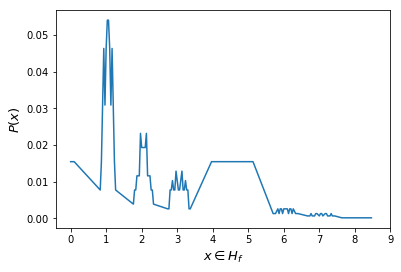

In [10]:
rankVprob = chances(Hand('11111'), [0,1,2,3,4])
x = np.vectorize(lambda x: x.rank_fine())(rankVprob['Score'])

if(__name__ == '__main__'):
    plt.plot(x, rankVprob['Probability'], '-')
    plt.xticks(range(0,10))
    plt.xlabel(r'$x \in H_f$', fontsize=13)
    plt.ylabel(r'$P(x)$', fontsize=13)
    plt.show()

In the above graph, the x-axis represents the numbers in $H_f$ and the y-axis is the corresponding likelihood of getting a hand with that $f$-value at random. We can see a large scale trend of exponential decay, which is sensible, it means that (very roughly), the higher $f$-value we get the more (exponentially) likely we are to win. To get a better view at the exponential decay let us clear up the above graph a bit by taking average of all the $f$-values that correspond to the same rank.

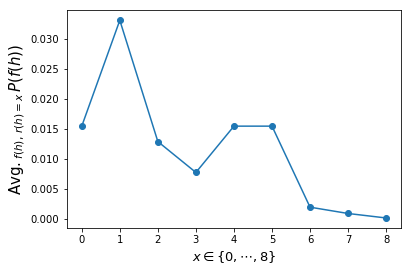

In [11]:
rankVprob_lim = rankVprob.copy()
rankVprob_lim['Score'] = np.vectorize(lambda x: x.rank())(rankVprob_lim['Score'])
rankVprob_lim['Probability'] = rankVprob_lim['Probability'].astype(float)
rankVprob_lim = pivot_table(rankVprob_lim, values='Probability', index=['Score'], aggfunc=np.mean)
rankVprob_lim = Series(rankVprob_lim['Probability'], index=rankVprob_lim.index)

if(__name__ == '__main__'):
    plt.plot(rankVprob_lim.index, rankVprob_lim.values, 'o-')
    plt.xlabel(r'$x \in \{0, \cdots, 8\}$', fontsize=13)
    plt.ylabel(r'$\mathrm{Avg.}_{f(h),\, r(h) = x}\, P(f(h))$', fontsize=15)
    plt.show()

There are still few data points that contradict the exponential decay, we can manually get rid of them and then use interpolation to get an exponential function. We then compare this function to the original plot.

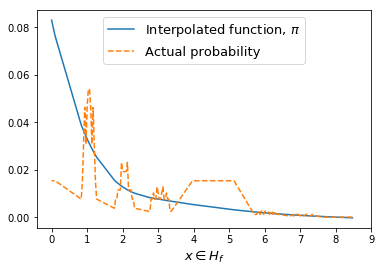

In [12]:
# The mask will get rid of the discrepant values
mask = [False, True, True, True, False, False, True, True, True]
rankVprob_nonAnom = rankVprob_lim.iloc[mask]

x_nonAnom = np.array(rankVprob_nonAnom.index)
y_nonAnom = np.array(rankVprob_nonAnom.values)

# Though we said that the function we are looking for looks exponential, for approximation purposes a cubic
# interpolation (or even a quadratic one) works just fine.
pi = InterpolatedUnivariateSpline(x_nonAnom, y_nonAnom, k=3)
# pi as defined in the above line will be used later, so it's crucial to keep this definition intact
# in form and substance throughout the notebook.

x_all = np.vectorize(lambda x: x.rank_fine())(rankVprob['Score'])
# x_all as defined in the above line will be used later, so it's crucial to keep this definition intact
# in form and substance throughout the notebook.

if(__name__ == '__main__'):
    y_old = rankVprob['Probability']
    y_new = pi(x_all)

    plt.plot(x_all, y_new, '-', label='Interpolated function, $\pi$')
    plt.plot(x_all, y_old, '--', label='Actual probability')
    plt.xticks(range(0,10))
    plt.legend(loc='upper center', fontsize=13)
    plt.xlabel(r'$x \in H_f$', fontsize=13)
    plt.show()

Our approximation looks OK, now we want to define a measure of strength $\phi: H_f \to \mathbb R$ for any hand $h$ which is the inverse of this approximated function, i.e.,
$$ \phi(f(h)) := \frac{1}{\pi(f(h))}\,. $$

In [13]:
def phi(rank):
    # This definition relies on pi and x_all that were defined previously, outside this function. This is not
    # in general a good idea. Defining pi inside this function would slow things down. I should save the data
    # of pi and x_all to a separate file and then import it.
    # We are going to define phi with a slight modification, we will insert a small number in the denominator
    # in addition to pi. The reason is that this allows us to avoid erratic behavious near the highest f-values
    # that would otherwise be cause by tiny outputs of pi.
    epsilon = 0.001
    
    return 1/(pi(rank)+epsilon)

Expectedly, this measure looks roughly exponential (cubic perhaps, but who can tell just by eyeballing!).

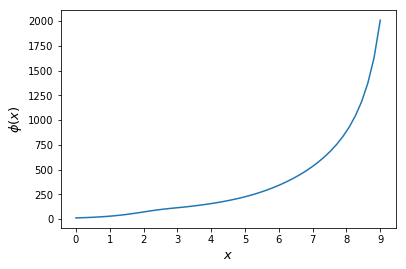

In [14]:
if(__name__ == '__main__'):
    x = np.linspace(0, 9, num=50, endpoint=True)
    plt.plot(x, np.vectorize(phi)(x))
    plt.xticks(range(0,10))
    plt.xlabel('$x$', fontsize=13)
    plt.ylabel('$\phi(x)$', fontsize=13)
    plt.show()

Having defined a measure of strength from the $f$-value of a hand $h$, we can proceed with our attempt at defining a metric for the choices of subsets $s \subseteq h$ to roll. The metric we want should have the following interpretation:
> The value of the metric for a subset $s \subseteq h$ should give us a measure of by how much we can expect the $f$-value of the hand to change if we roll the dices in $s$.

To express whether the $f$-value $f(h_1)$ is better or worse than the $f$-value $f(h_2)$ we can use the [sign function](https://en.wikipedia.org/wiki/Sign_function) $\mathrm{sgn}(f(h_2) - f(h_1))$. Now, if for a hand $h$ and a subset $s \subseteq h$, we denote by $R_h(s) \subseteq H$ the set of all possible outcomes after rolling the dices in $s$, then a good metric value for the subset $s$ can be something like the following expectation value:
$$ \mathbb E^\rho_{\xi \in f(R_h(s))} \big(\mathrm{sgn}(\xi - f(h))\big)\,, $$
where $\rho$ denotes a choice of probability distribution on the domain $f(R_h(s))$. Our goal then is to make a judicious choice of the distribution $\rho$ which will in general depend on both $h$ and $s$.

Note that, $\phi$ allows us to compare two $f$-values relative to each other, i.e., for two hands $h_1$ and $h_2$, the ratio $\frac{\phi(f(h_1))}{\phi(f(h_2))}$ tells us how much stronger the hand $h_1$ is compared to $h_2$ and, roughly speaking, this varies exponentially with $f(h_1)$. Therefore this ratio is a good weight to assign to $f(h_1)$ relative to $f(h_2)$, except, for weights less than 1, we still wish to view them as exponentially larger than 1 but with a negative sign. To that end we dfine:
$$ \forall x, y \in \mathbb R\, \quad \chi_y(x) := y^{\theta(-x)} x\,, \qquad \forall h, \in H,\, y \in \mathbb R\; \mbox{and}\; \xi \in H_f, \quad \phi_{h,y}(\xi) := \left(\frac{\phi(\xi)}{\phi(f(h))} \right)^{\chi\left(\mathrm{sgn}\left(\xi-f(h)\right)\right)}\,,$$
We should normalize this weight, let us introduce a notation for normalization: for any function $\psi: A \to B$ between any two sets $A$ and $B$, given a subset $C \subseteq A$, we denote by $N_C(\psi)$ a normalized function $N_C(\psi) : C \to B$, such that:
$$ \forall \xi \in C\,, \quad N_C(\psi)(\xi) := \frac{\psi(\xi)}{\sum_{\zeta \in C} \psi(\zeta)}\,. $$
Our normalized weight now becomes $N_{f(R_h(s))}(\phi_{h,y})$.

We have an interesting distribution in $N_{f(R_h(s))}(\phi_{h,y})$, but the proper choice should also involve the probability distribution of the possible outcomes ($f$-values), which we denote by $P$. Finally, our ansatz for the proper distribution over $f(R_h(s))$ is:
$$ \rho_{h,s} := N_{f(R_h(s))}\left(N_{f(R_h(s))}(\phi_{h,y}) P\right)\,. $$
With this our choice of metric becomes:
$$ \forall h \in H,\, s \subseteq h, \quad g_h(s) := \mathbb E^{\rho_{h,s}}_{\xi \in f(R_h(s))} \big(\mathrm{sgn}(\xi - f(h)) \big)\,.$$

In the following we implement this metric and call it `base_score`.

In [42]:
# "base_score" takes as input a "Hand" object and a list containing the positions of the dices to roll,
# called "to_roll". The output of "base_score" is a real number which is the value of the metric defined
# just above. The optional argument "diag" provides some diagnostic plots to see how the scorings behave.
def base_score(hand, to_roll=[], diag=False):
    assert(type(hand) == Hand and len(hand.pattern) == 5)
    
    prospect = chances(hand, to_roll)
    size = prospect.shape[0]
    current_weight = phi(hand.score().rank_fine())
    weights = np.vectorize(phi)(np.vectorize(lambda x: x.rank_fine())(prospect['Score'])) / current_weight
    negative_exponent = 2 # loss is more heavily oppressed than win is promoted
    positive_exponent = 1
    weights = weights ** np.vectorize(lambda x: positive_exponent*x if x>0 else negative_exponent*x)(prospect['Improvement'])
    weights /= sum(weights)
    nu_weights = weights * prospect['Probability']
    nu_weights /= sum(nu_weights)
    possible_scores = np.vectorize(lambda x: x.rank_fine())(prospect['Score'])
    
    if(diag):
        #print(DataFrame(weights, index=possible_scores))
        _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
        ax1.plot(possible_scores, weights, 'o-', label='Normalized weight, $N_{f(R_h(s))}(\phi_{h,2})$')
        ax1.plot(possible_scores, prospect['Probability'], '--', label='Probability')
        ax1.set_xlabel('Possible $f$-values')
        ax1.legend(loc='upper center', bbox_to_anchor=(.5, 1.28), fontsize=13)
        ax1.axvline(x=hand.score().rank_fine(), color='k')
        
        ax2.plot(possible_scores, nu_weights, 'o-')
        ax2.set_xlabel('Possible $f$-values')
        ax2.set_ylabel('Probability adjusted weight')
        ax2.axvline(x=hand.score().rank_fine(), color='k')
        
        plt.show()
        
    return sum(prospect['Improvement']  * nu_weights)

Example of how the scoring works for a random hand and a random subset to roll. The black line in the plots is at the position corresponding to the $f$-value of the current hand (prior to rolling the dices in $s$).

Hand (h) = 43454, to_roll (s) = [0, 2, 1]


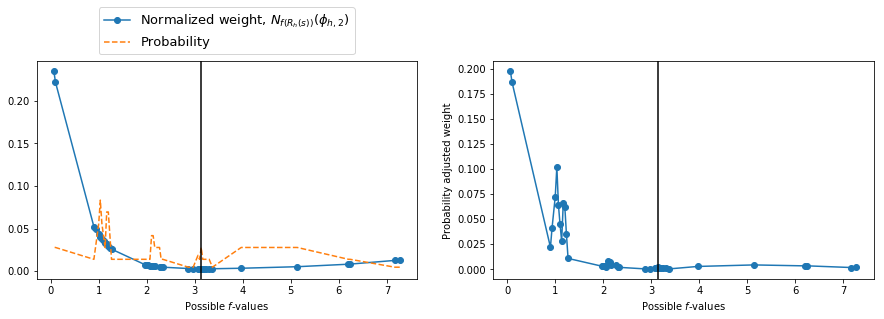

In [16]:
if(__name__ == '__main__'):
    hand = roll()
    n = 3
    to_roll = [int(x) for x in list(permutations('01234', n))[random.randint(0, factorial(5)/factorial(5-n) - 1)]] # 5Pn = 5!/(5-n)!
    print('Hand (h) = ' + str(hand) + ', to_roll (s) = ' + str(to_roll))
    base_score(hand, to_roll, diag=True)

## The greedy choice
Once we have this metric, we can simply define the greedy optimizer $\mathcal O_0: h \to h^2$ to be a function that chooses a subset $s \subseteq h$ that maximizes it:
$$ \mathcal O_0(h) := \underset{s \in h^2}{\mathrm{argmax}}\, g_h(s)\,. $$
Let us now implement this greedy optimizer.

In [17]:
# Rolling all 5 dices is an optimum choice only if the opponent has a '5 of a kind' of n and
# I don't have any dice of value >= n. I will ignore this possibility since it's easy to handle
# these cases manually and they are too costly for the program.
# The function "second_choices" outputs a list of lists. The sublists are lists of positions (from 0 to 4)
# and represents the dices to roll.
def second_choices():
    choices = []
    for i in range(0,31):
        bini = bin(i)[2:]
        #if(bini.count('1') > 3):
        #    continue
        bini = ''.join(['0']*(5-len(bini))) + bini
        bini = Series(np.array([c for c in bini]))
        choices.append(list(bini[bini == '1'].index))
    return choices

In [18]:
# "greedy_choice" is the function that takes in a "Hand" object as input and outputs the subset
# (as a list of positions) that maximizes the metric defined in the last section.
def greedy_choice(hand):
    assert(type(hand) == Hand and len(hand.pattern) == 5)
    
    choices = second_choices()
    scored_choices = [[choice, base_score(hand, choice)] for choice in choices]
    options = DataFrame(scored_choices, columns=['To Roll', 'Score'])
    options = options.sort_values('Score', ascending=False)
    
    return options.loc[options['Score'].idxmax()]['To Roll']
# One exemplary case where the greedy choice differs from the optimum choice is the following:
# my hand = 54361, opponent's hand = 44225
# optimum choice = [0, 1, 2, 4] with p_loss_max = .69
# greedy choice = [3, 4] with p_loss_max: 0.76

# Computing Losses
We will assume that the opponent will play the best (for the opponent) possible move and then compute the probability of not winning.

In [19]:
# "p_loss" computes the probability of not winning if we roll "to_roll1" and the opponent rolls "to_roll2" if our current
# hand is "hand1" and the opponent's current hand is "hand2".
def p_loss(hand1, to_roll1, hand2, to_roll2):
    assert(type(hand1) == Hand and type(hand2) == Hand)
    
    chances1 = chances(hand1, to_roll1)
    chances2 = chances(hand2, to_roll2)
    
    return sum([chances1['Probability'][i1] * chances2['Probability'][i2] for i1 in chances1.index for i2 in chances2.index if chances1['Score'][i1] <= chances2['Score'][i2]])

In [20]:
# "p_loss_max" computes the probability of not winning if we roll "to_roll1" given that our current hand is "hand1"
# and the opponent's current hand is "hand2", assuming that the opponent will play the move that maximizes his
# chance of winning.
def p_loss_max(hand1, to_roll1, hand2, rolls=[]):
    #start_time = time.time()
    if(rolls == []):
        rolls = second_choices()
    
    p_losses = [p_loss(hand1, to_roll1, hand2, to_roll2) for to_roll2 in rolls]
    p_max = max(p_losses)
    return p_max

## How good is the greedy optimizer?
Now that have the functions to compute our chances of not winning, we can try to figure out how well the greedy optimzer works. Since this game is completely symmetric between the two players, if both of them plays perfectly, the distribution of the outcomes should be perfectly symmetric, i.e., if we play a large number of times, after the first roll, assuming perfect play, our chances of not winning should follow a symmetric distribution with mean 0.5. Let's see how our greedy optimzer fares in this respect.

Mean: 0.525705107596, Median: 0.52237654321


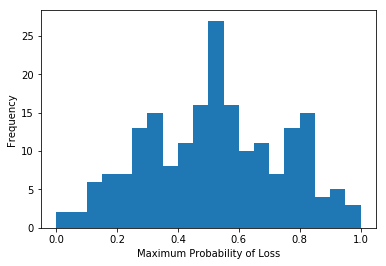

Time took: 241.50951743125916s.


In [21]:
if(__name__ == '__main__'):
    start_time = time.time()
    sample_size = 200
    n_bins = int(sample_size/10)
    rolls = second_choices()
    p_loss_distro = [(lambda x: p_loss_max(x, greedy_choice(x), roll(), rolls))(roll()) for i in range(sample_size)]
    plt.hist(p_loss_distro, bins=n_bins, range=(0,1))
    plt.xlabel('Maximum Probability of Loss')
    plt.ylabel('Frequency')
    print('Mean: ' + str(np.mean(p_loss_distro)) + ', Median: ' + str(np.median(p_loss_distro)))
    plt.show()
    print('Time took: ' + str(time.time()-start_time) + 's.')

We see that the mean and the median of the distribution are farely close to 0.5 which tells us that the greedy optimzer is pretty close to being truly optimum. The defect of the greedy optimizer is almost noticable in the graph above, the graph has some relatively high values near one, which is due to the fact that the greedy optimizer always tries to maximize the expected value of our final score, even when doing so means that we absolutely can not win. These cases, when the greedy optimizer is particularly bad, our chances of winning are slim anyway and going back to my original motivation for writing this notebook, I will just reload the game from the last save point, which is of course immediately prior to beginning the game (ragardless of how many orens I have, I am not going to loose even 20 of them because of chance!)

That being said, there is still room for fine tuning in the greedy optimizer.

# The Optimum Move
> The optimum choice is the one that minimizes the maximum probability of not winning.

It is actually completely straightforward to define and much simpler than the greedy choice, unfortunately it is also much slower.

In [22]:
# the "optimize" function takes in two "Hand" objects, and outputs a "Series" object with two indices, "Roll' and "P_loss".
# The "Roll" value corresponds to the optimum choice of subset of the "hand1" to roll and the "P_loss" value corresponds
# to the maximum probability of not winning when we roll the optimum choice.
# It simply goes through all the possible subsets of "hand1", for each it finds the move for "hand2" that
# maximizes the probability of loss for "hand1" and then chooses the subset that corresonds to the minimum
# of such probabilities.
def optimize(hand1, hand2):
    rolls = second_choices()
    
    roll_p_loss = [[to_roll1, p_loss_max(hand1, to_roll1, hand2, rolls)] for to_roll1 in rolls]
    roll_p_loss = DataFrame(roll_p_loss, columns=['Roll', 'P_loss'])
    min_id = roll_p_loss['P_loss'].idxmin()
    
    return roll_p_loss.loc[min_id]

Finally, let us look at both of our optimizers (the greedy one and the truly optimum one) in action with some randomly generated (or manually provided) test cases.

In [46]:
if(__name__ == '__main__'):
    start_time = time.time()
    
    # To use this for the purpose of playing actual games (as in The Witcher 2), replace "roll()" in the following
    # two lines with two length 5 strings containing numbers only representing dices.
    hand_my = roll() # Replace with the player's hand, example: Hand('51342').
    hand_op = roll() # Replace with the opponent's hand, example: Hand('34323').
    print('My hand: ' + str(hand_my) + ', Opponent\'s hand: ' + str(hand_op))
    
    base = greedy_choice(hand_my)
    print('greedy choice: ' + str(base) + ', Max p of loss: ' + str(p_loss_max(hand_my, base, hand_op)))
    print('Time took: ' + str(time.time() - start_time) + 's.')
    start_time = time.time()
    
    opt_choice = optimize(hand_my, hand_op)
    print('Optimum choice: ' + str(opt_choice['Roll']) + ', Max p of loss: ' + str(opt_choice['P_loss']))
    print('Time took: ' + str(time.time()-start_time) + 's.')

My hand: 43466, Opponent's hand: 62336
greedy choice: [1], Max p of loss: 0.40432098765432134
Time took: 0.7048885822296143s.
Optimum choice: [1], Max p of loss: 0.404320987654
Time took: 47.16719698905945s.
